In [1]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image

# for visualizations
import matplotlib.pyplot as plt
import pandas as pd # create dataframe
import numpy as np # for using np arrays

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

## Load dataset function 


In [2]:
def LoadData_one(path1, path2,pet_df):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)
    #IM_name = pet_df['image_name'].iloc[i]
    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for i in range(len(image_list)):
        if pet_df['pet_images'].iloc[i] in image_dataset and  (pet_df['image_name'].iloc[i]+".png") in mask_dataset:
            orig_img.append(pet_df['pet_images'].iloc[i])

            mask_img.append(pet_df['image_name'].iloc[i]+".png")

    # Sort the lists to get both of them in same order (the dataset has exactly the same name for images and corresponding masks)
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

In [3]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # convert image into an array of desired shape (3 channels)
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

In [4]:
## get a list of all jpg files
image_list=[]
for file in os.listdir("/Users/napro/Desktop/Masters-Work/U-NET/dataset/images/images/"):
    if file.endswith(".jpg"):
#         print(file)
        image_list.append(file)

In [5]:
#creat file with pet_names and image names
pet_df = pd.DataFrame(np.nan, index = np.arange(len(image_list)), columns = ['pet_images'])
pet_df['pet_images']= image_list
pet_df['image_name'] = pet_df.pet_images.str.split(pat = '.', expand = True)[0]

In [6]:
pet_df.head()

pet_images        image_name
0  Egyptian_Mau_167.jpg  Egyptian_Mau_167
1            pug_52.jpg            pug_52
2  basset_hound_112.jpg  basset_hound_112
3       Siamese_193.jpg       Siamese_193
4     shiba_inu_122.jpg     shiba_inu_122

(400, 600, 3)
(256, 256)


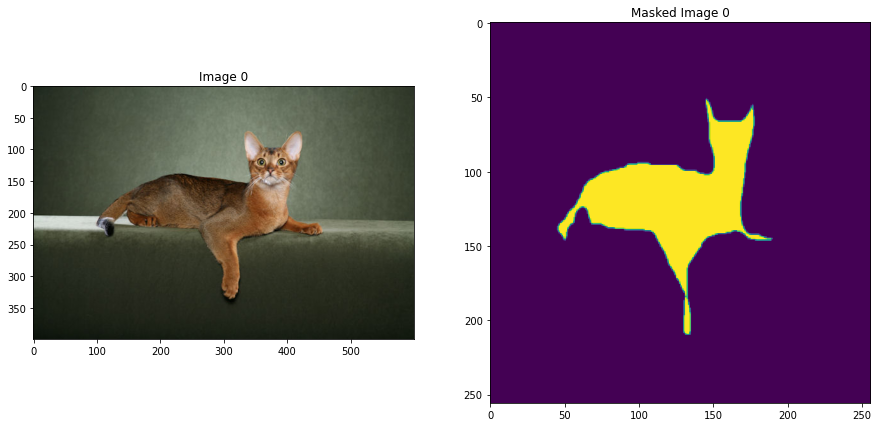

In [7]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = '/Users/napro/Desktop/Masters-Work/U-NET/dataset/images/images/'
path2 = '/Users/napro/Desktop/Masters-Work/U-NET/masks/'
img, mask = LoadData_one (path1, path2,pet_df)

# View an example of image and corresponding mask 
show_images = 1
for i in range(show_images):
    
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

Text(0.5, 1.0, 'Processed Masked Image ')

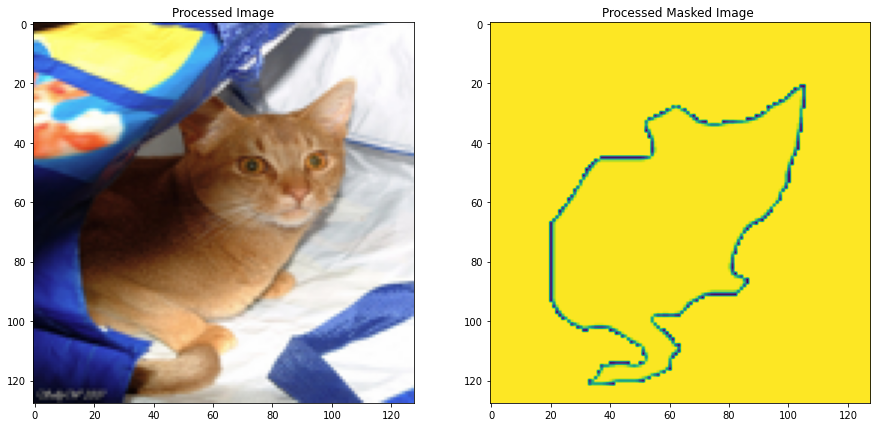

In [8]:
#Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 2
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## Constructing the U-Net Architecture

### U-Net Encoder Block

In [9]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

### U-Net Decoder Block

In [10]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Compile U-Net Blocks

In [11]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):

    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output 
    """
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

## Executing above Functions to Train the Model

### Load and View Data

(400, 600, 3)
(256, 256)


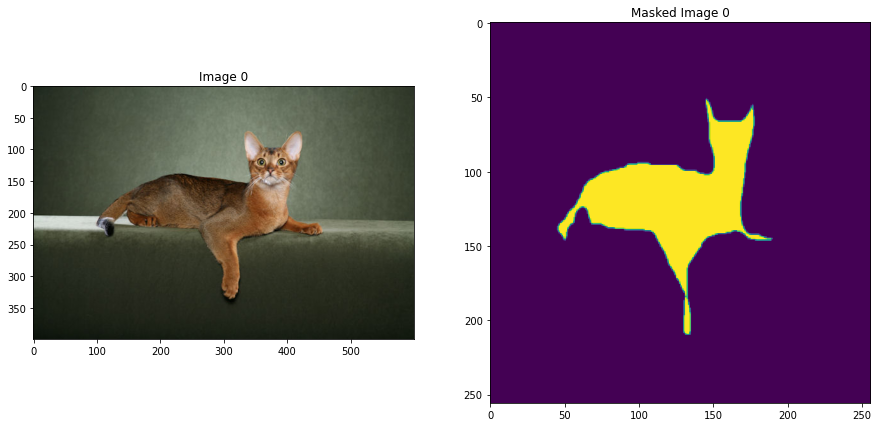

In [12]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = '/Users/napro/Desktop/Masters-Work/U-NET/dataset/images/images/'
path2 = '/Users/napro/Desktop/Masters-Work/U-NET/masks/'
img, mask = LoadData_one(path1, path2,pet_df)

# View an example of image and corresponding mask 
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

## Process Data

X Shape: (7390, 128, 128, 3)
Y shape: (7390, 128, 128, 1)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

Text(0.5, 1.0, 'Processed Masked Image ')

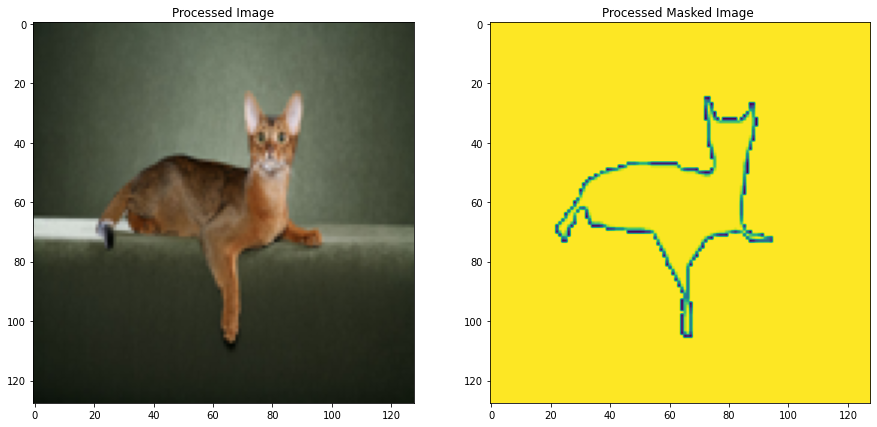

In [13]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset 
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# There are 3 classes : background, pet, outline
print(np.unique(y))

# Visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

### Split Train and Test Set

In [14]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

### Build U-Net Architecture

In [15]:
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [16]:
unet.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
_______________________________________________________________________________________

## Compile and Run Model

In [17]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
model =unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


InvalidArgumentError:  Received a label value of 255 which is outside the valid range of [0, 3).  Label values: 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 127 127 127 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 121 240 254 254 254 251 155 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 146 254 254 254 254 254 254 254 211 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 240 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 121 248 254 254 254 254 254 254 254 254 254 254 239 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 183 254 254 254 254 254 254 254 254 254 254 254 254 254 244 125 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 66 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 212 254 223 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 15 19 191 247 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 185 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 83 255 255 18 131 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 4 123 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 28 255 255 255 255 103 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 89 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 91 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 34 166 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 3 149 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 99 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 40 112 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 41 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 167 254 254 254 254 254 254 254 254 254 250 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 190 70 136 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 252 254 254 254 254 254 254 243 42 255 4 176 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 235 254 254 254 254 254 254 181 255 255 255 36 222 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 222 254 254 254 254 254 254 100 255 255 255 255 150 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 224 254 254 254 254 254 235 28 255 255 255 255 126 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 220 254 254 254 254 254 176 255 255 255 255 255 157 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 177 254 254 254 254 254 126 255 255 255 255 5 190 254 254 236 176 224 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 254 254 254 254 254 117 255 255 255 255 11 219 254 247 91 1 61 239 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 250 254 254 254 254 124 255 255 255 255 9 211 254 214 7 255 255 181 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 218 254 254 254 254 171 0 255 255 255 0 158 254 166 255 255 255 128 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 139 254 254 254 254 177 0 255 255 255 255 137 254 146 255 255 255 141 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 243 254 254 254 221 9 255 255 255 8 196 254 107 255 255 1 181 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 249 85 255 255 43 153 254 251 80 255 255 10 208 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 232 131 145 238 254 254 245 45 255 255 20 245 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 250 254 254 254 254 254 254 254 254 254 201 9 255 255 6 122 249 242 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 235 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 162 249 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 210 254 254 254 254 254 254 254 254 254 93 255 255 255 255 255 103 247 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 188 254 254 254 254 254 254 254 254 245 42 255 255 255 255 255 123 250 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 235 254 254 254 254 254 254 254 154 3 255 255 255 255 6 202 251 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 233 254 254 250 176 114 108 21 255 255 255 255 255 11 179 206 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 158 234 77 2 255 255 255 255 255 255 255 255 255 4 23 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 45 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 44 45 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 94 222 247 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 244 245 239 151 135 137 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 110 133 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 148 94 15 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 151 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 189 94 63 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 249 189 146 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 106 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 183 87 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 92 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 160 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 148 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 67 29 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 241 173 119 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 138 23 1 1 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 179 181 183 118 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 45 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 222 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 94 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 145 149 146 182 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 17 255 255 255 12 117 188 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 14 255 255 255 255 255 255 4 66 156 224 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 77 255 255 255 255 255 255 255 255 255 0 13 54 136 234 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 16 255 255 255 255 255 255 255 255 255 255 255 255 255 32 42 161 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 67 123 202 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 227 254 254 254 254 254 254 254 254 244 253 254 254 254 254 205 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 75 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 152 98 16 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 252 254 254 254 254 254 254 250 157 44 86 184 254 254 254 205 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 182 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 206 111 110 45 6 7 255 255 7 7 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 188 254 254 254 254 254 254 254 197 7 255 255 30 240 254 254 207 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 88 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 200 202 115 118 202 202 196 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 252 254 254 254 254 254 254 250 107 255 255 255 0 163 254 254 195 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 154 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 157 254 254 254 254 254 254 254 213 10 255 255 255 255 129 254 249 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 91 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 227 254 254 254 254 254 251 192 124 255 255 255 255 12 220 254 204 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 244 254 254 254 254 247 114 18 23 255 255 255 255 15 236 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 214 7 255 255 255 255 255 255 15 236 249 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 244 87 255 255 255 255 255 255 255 15 236 249 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 153 254 254 254 233 77 255 255 255 255 255 255 255 255 15 236 249 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 225 254 254 254 176 255 255 255 255 255 255 255 255 255 15 236 249 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 253 254 254 185 47 255 255 255 255 255 255 255 255 255 15 235 252 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 239 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 201 254 254 214 23 255 255 255 255 255 255 255 255 255 255 16 237 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 118 30 25 64 161 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 151 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 9 210 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 146 29 255 255 255 255 255 80 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 153 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 92 250 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 255 82 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 82 0 255 255 255 255 255 255 255 71 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 251 254 254 254 247 60 255 255 255 255 255 255 255 255 255 255 255 255 20 222 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 85 255 255 255 255 255 255 255 255 255 255 67 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 66 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 254 254 254 254 200 14 255 255 255 255 255 255 255 255 255 255 255 255 255 180 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 255 255 255 255 255 255 255 255 255 255 255 255 63 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 233 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 28 255 255 255 255 255 255 255 255 255 255 255 255 255 77 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 237 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 254 160 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 247 254 254 254 254 254 254 254 254 254 254 254 254 254 187 1 255 255 255 255 255 255 255 255 255 255 255 255 255 13 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 254 254 211 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 247 254 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 2 182 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 253 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 202 254 254 254 254 254 254 254 254 254 254 254 254 254 196 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 196 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 223 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 253 254 254 254 254 254 254 254 254 254 246 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 174 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 162 167 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 175 254 254 228 106 111 233 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 253 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 245 91 255 255 101 248 254 254 254 254 254 254 254 217 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 240 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 254 199 5 255 255 9 214 254 254 254 254 254 254 254 244 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 132 241 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 116 255 255 255 255 83 245 254 254 254 254 254 254 253 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 189 244 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 108 255 255 255 255 255 82 235 254 254 254 254 254 254 210 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 187 244 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 109 255 255 255 255 255 255 115 254 254 254 254 254 254 254 160 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 185 245 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 109 255 255 255 255 255 255 5 176 254 254 254 254 254 254 252 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 207 253 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 109 255 255 255 255 255 255 255 80 251 254 254 254 254 254 254 239 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 252 254 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 109 255 255 255 255 255 255 255 2 159 254 254 254 254 254 254 254 194 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 149 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 109 255 255 255 255 255 255 255 255 56 242 254 254 254 254 254 254 168 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 188 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 106 255 255 255 255 255 255 255 255 2 69 243 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 253 254 254 254 254 254 254 254 254 254 254 254 254 254 253 179 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 242 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 254 135 255 255 255 255 255 255 255 255 255 1 192 254 254 254 254 254 197 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 185 253 254 254 254 254 254 254 254 254 254 254 254 254 225 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 211 254 254 172 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 229 212 15 255 255 255 255 255 255 255 255 255 52 235 254 254 254 254 243 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 208 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 245 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 211 253 76 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 185 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 254 172 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 176 254 158 255 255 255 255 255 255 255 255 255 255 53 229 254 254 254 254 243 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 238 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 247 254 254 243 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 254 230 49 255 255 255 255 255 255 255 255 255 255 101 252 254 254 254 254 223 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 147 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 210 254 254 254 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 179 254 205 63 255 255 255 255 255 255 255 255 255 3 161 254 254 254 254 254 179 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 246 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 139 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 216 254 225 81 0 255 255 255 255 255 255 255 255 19 209 254 254 254 254 254 155 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 233 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 254 194 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 243 254 246 139 0 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 160 4 255 255 255 255 255 255 255 255 255 255 255 255 255 0 169 254 254 254 254 254 254 254 254 254 254 154 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 169 90 86 63 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 254 254 252 85 255 255 255 255 255 255 255 255 25 217 254 254 254 254 254 183 5 255 255 255 255 255 255 255 255 255 255 255 255 255 5 196 254 254 254 254 254 254 254 254 254 254 216 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 239 254 254 224 43 255 255 255 255 255 255 255 255 137 254 254 254 254 251 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 110 254 254 254 254 254 254 254 254 254 254 216 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 189 254 254 158 255 255 255 255 255 255 255 255 11 193 254 254 254 253 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 224 254 254 254 254 254 254 254 254 215 87 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 130 254 144 255 255 255 255 255 255 255 255 255 104 254 254 254 254 223 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 249 254 254 254 254 254 254 185 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 94 30 255 255 255 255 255 255 255 255 255 34 236 254 254 254 254 180 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 151 254 254 254 254 254 226 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 166 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 199 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 239 254 254 254 254 242 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 171 173 173 167 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 164 254 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 179 254 254 254 254 236 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 252 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 162 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 251 254 254 254 238 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 154 254 254 254 254 133 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 201 254 254 254 249 158 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 238 254 254 254 254 239 88 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 254 242 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 122 146 179 248 254 254 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 64 178 180 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 2 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 170 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 221 233 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 244 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 111 98 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 208 254 254 248 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 113 227 254 217 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 162 254 254 254 250 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 164 254 254 254 209 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 252 140 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 157 254 254 254 254 209 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 248 254 254 254 254 254 157 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 201 254 254 254 254 254 210 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 217 254 254 254 254 254 254 210 101 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 164 254 254 254 254 254 254 199 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 167 254 254 254 254 254 254 254 254 199 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 158 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 252 254 254 254 254 254 254 254 254 178 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 165 254 254 254 254 254 254 254 242 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 213 254 254 254 254 254 254 254 254 254 185 89 39 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 182 254 254 254 254 254 254 254 254 178 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 236 183 95 58 61 61 27 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 243 254 254 254 254 254 254 254 254 253 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 249 249 224 193 109 61 64 45 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 230 254 254 254 254 254 254 254 254 254 176 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 250 238 187 132 68 65 39 9 9 9 9 9 9 9 9 9 51 201 254 254 254 254 254 254 254 254 254 253 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 250 233 211 212 212 212 212 212 212 212 212 239 254 254 254 254 254 254 254 254 254 254 214 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 36 48 107 153 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 38 107 112 142 211 242 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 93 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 108 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 183 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 44 157 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 110 181 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 181 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 122 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 159 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 98 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 125 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 49 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 105 211 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 137 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 255 255 31 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 255 45 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 2 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 41 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 67 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 41 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 12 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 3 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 26 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 39 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 161 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 217 149 116 97 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 33 255 6 113 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 196 184 127 58 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 156 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 25 107 146 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 191 64 6 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 29 118 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 97 38 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 155 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 14 255 255 255 255 255 255 255 255 119 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 158 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 150 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 16 255 255 255 255 255 255 255 31 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 197 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 87 146 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 3 255 255 255 255 255 255 28 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 109 35 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 97 120 188 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 66 255 255 255 255 255 255 82 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 41 127 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 17 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 87 158 175 222 239 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 239 217 171 121 58 58 156 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 23 255 255 255 17 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 18 25 75 100 97 97 97 97 97 97 97 97 97 97 97 97 100 69 24 16 255 255 255 255 255 90 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 47 14 63 188 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 230 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 8 8 8 8 8 8 7 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 56 119 139 204 206 206 206 206 206 207 194 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 187 247 254 254 254 254 254 254 254 254 254 254 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 124 241 254 254 254 254 254 254 254 254 254 254 254 254 222 102 19 3 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 129 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 188 192 159 102 40 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 233 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 141 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 107 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 119 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 139 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 185 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 114 161 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 156 158 159 143 104 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 11 255 255 255 255 255 46 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 4 255 255 255 255 255 255 255 114 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 31 255 255 255 255 255 255 255 255 4 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 12 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 22 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 6 5 26 115 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 11 255 255 255 255 255 255 255 255 255 255 255 255 13 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 111 118 189 199 197 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 61 169 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 83 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 207 240 148 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 251 254 254 254 254 254 254 254 254 254 254 254 254 252 126 20 8 50 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 201 254 254 254 254 254 254 254 254 254 254 254 254 254 196 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 152 254 254 254 254 254 254 254 254 254 254 209 141 138 139 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 241 254 254 254 254 254 254 254 254 254 190 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 253 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 35 135 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 243 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 16 37 101 173 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 118 254 254 254 254 254 254 254 254 254 247 54 255 255 255 255 255 255 255 255 255 34 142 149 149 149 149 149 145 194 237 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 10 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 172 254 254 254 254 254 254 254 254 254 229 40 255 255 255 255 255 255 255 255 124 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 176 254 254 254 254 254 254 254 254 250 98 255 255 255 255 255 255 255 255 67 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 173 254 254 254 254 254 254 254 254 199 4 255 255 255 255 255 255 255 19 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 190 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 233 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 2 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 223 211 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 227 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 4 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 96 39 12 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 53 119 178 249 254 254 254 254 254 125 255 255 255 255 255 255 255 4 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 186 81 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 80 225 254 254 254 254 129 255 255 255 255 255 255 255 4 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 88 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 132 242 254 254 180 2 255 255 255 255 255 255 4 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 186 113 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 182 244 233 17 255 255 255 255 255 255 4 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 37 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 51 127 35 255 255 255 255 255 255 20 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 225 173 168 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 255 255 43 200 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 205 207 180 120 61 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 8 8 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 129 121 120 120 120 120 122 87 59 20 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 212 254 254 254 254 254 254 254 248 229 182 141 114 115 115 116 110 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 33 60 58 58 62 114 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 150 87 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 158 165 192 236 249 248 248 249 238 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 109 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 162 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 140 250 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 111 213 254 254 254 254 254 254 254 254 254 231 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 111 28 255 255 255 255 255 255 255 255 255 255 255 5 24 38 37 39 82 95 94 94 96 72 27 35 38 28 255 255 255 255 255 255 255 255 255 255 255 72 149 231 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 124 41 9 255 255 255 4 21 51 107 148 195 226 243 243 243 254 254 254 254 254 252 230 240 243 232 167 92 41 30 11 5 5 5 14 58 166 250 254 254 254 254 254 254 254 254 254 254 254 254 211 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 159 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 205 153 137 147 193 227 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 240 206 195 196 195 214 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 44 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 181 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 224 150 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 171 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 163 80 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 77 169 216 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 110 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 41 115 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 118 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 170 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 120 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 151 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 183 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 73 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 50 59 56 83 138 195 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 128 198 245 248 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 61 169 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 185 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 26 59 120 206 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 181 156 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 198 231 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 31 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 120 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 92 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 96 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 208 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 29 120 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 172 124 81 68 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 15 15 15 15 52 68 67 104 129 177 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 42 97 121 133 172 205 234 232 232 232 245 251 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 227 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 110 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 168 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 127 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 91 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 2 24 26 54 85 108 142 142 142 142 142 142 142 140 95 84 85 85 85 85 85 85 85 85 85 85 85 85 85 85 85 86 77 31 26 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 142 61 21 55 84 128 184 231 240 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 241 236 196 156 100 43 21 23 23 23 23 23 23 23 23 23 14 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 238 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 238 239 239 239 239 239 239 239 239 239 213 51 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 91 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 239 226 190 190 178 134 132 133 132 138 186 191 154 129 149 189 190 189 189 189 189 189 189 189 189 189 189 189 189 188 202 238 239 239 239 239 239 239 239 239 239 239 239 239 239 237 202 161 130 133 133 133 105 9 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 220 139 82 30 24 19 4 4 1 255 255 255 255 255 3 4 255 255 255 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 9 24 25 25 25 25 25 25 25 25 25 25 25 25 25 24 8 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 173 141 106 64 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 103 103 102 117 158 159 159 160 201 231 247 246 246 246 246 246 246 246 246 246 246 246 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 28 52 51 51 51 51 51 51 51 51 51 51 51 60 105 108 107 112 160 168 216 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 68 115 163 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 120 119 119 119 119 119 119 119 118 135 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 56 12 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 110 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 217 187 165 127 59 12 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 220 182 149 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 124 125 111 70 57 16 15 15 13 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 247 232 232 233 227 174 85 29 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 192 136 82 30 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 87 89 88 88 88 88 88 88 87 104 146 193 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 191 164 137 110 83 50 53 35 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 62 141 211 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 247 234 215 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 69 142 196 236 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 34 68 123 179 217 226 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 11 23 53 54 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 54 94 111 110 110 110 110 110 110 110 110 109 121 165 167 166 166 166 164 187 223 223 224 245 248 252 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 12 12 15 52 58 71 125 172 216 245 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 49 89 122 120 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 5 5 5 5 5 5 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 63 119 120 119 151 196 195 195 195 195 195 195 195 139 52 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 171 248 254 254 254 254 254 254 254 254 254 254 254 254 254 247 206 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 136 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 188 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 185 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 132 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 182 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 159 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 152 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 185 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 159 81 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 208 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 253 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 246 224 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 199 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 222 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 175 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 243 87 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 64 136 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 254 248 163 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 87 144 220 250 254 168 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 254 254 254 218 137 68 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 212 254 254 254 254 254 179 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 254 254 254 254 254 251 228 118 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 136 253 254 254 254 254 254 254 148 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 243 254 254 254 254 254 254 254 254 254 254 254 254 217 138 98 25 2 3 3 3 2 255 255 255 255 255 255 255 255 255 255 255 20 64 168 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 185 186 186 187 185 130 104 41 26 2 1 1 1 1 11 84 213 250 254 254 254 254 254 254 254 254 253 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 226 182 181 181 181 179 202 253 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 142 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 142 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 142 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 92 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 82 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 179 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 157 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 183 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 113 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 132 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 120 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 66 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 189 92 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 93 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 182 91 28 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 180 107 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 139 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 79 166 188 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 79 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 74 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 127 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 188 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 222 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 58 141 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 221 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 245 194 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 214 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 229 254 254 205 70 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 109 206 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 250 190 56 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 76 192 254 254 254 228 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 248 201 168 123 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 152 221 253 254 254 254 254 200 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 247 150 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 244 254 254 254 254 254 254 254 107 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 245 254 254 254 254 254 254 254 254 254 254 254 217 126 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 199 254 254 254 254 254 254 254 214 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 221 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 252 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 224 254 254 254 254 254 254 254 248 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 98 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 150 236 254 254 254 254 254 254 254 254 223 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 101 228 254 254 254 254 254 254 254 254 254 254 222 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 181 254 254 254 254 254 254 254 254 254 254 254 254 222 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 147 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 7 255 255 255 255 255 255 255 255 255 255 255 255 3 3 3 3 3 3 3 3 3 3 3 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 43 255 255 255 255 255 255 13 64 113 127 154 188 186 186 186 186 186 186 186 186 186 186 185 146 97 64 19 13 255 255 255 255 255 255 255 255 1 104 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 158 122 75 87 126 166 218 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 238 227 123 36 13 1 255 5 15 62 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 225 178 172 196 233 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 185 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 68 150 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 208 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 148 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 66 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 133 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 170 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 65 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 136 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 162 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 76 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 242 238 238 238 238 238 223 185 145 127 127 127 127 127 127 127 130 172 205 237 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 190 115 75 33 18 19 19 19 19 15 2 255 255 255 255 255 255 255 255 255 255 9 17 43 80 123 172 190 194 236 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 240 235 194 145 115 45 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 6 20 53 126 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 221 254 254 254 254 254 254 254 254 247 235 178 140 97 86 86 45 29 27 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 217 242 242 242 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 254 254 254 254 254 250 216 190 122 53 28 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 36 35 34 49 91 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 92 91 102 145 182 212 241 244 244 244 244 232 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 222 165 136 66 14 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 12 39 41 41 41 41 39 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 113 81 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 14 14 14 14 14 14 14 14 14 14 49 86 84 84 39 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 138 209 231 229 229 229 229 229 229 229 229 228 242 254 254 254 239 182 122 77 79 72 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 247 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 114 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 155 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 114 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 133 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 67 147 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 218 234 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 123 11 58 98 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 234 195 140 91 40 63 75 62 63 64 63 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 234 243 252 249 249 250 249 221 119 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 191 116 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 118 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 167 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 132 117 117 117 117 117 118 114 55 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 221 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 115 35 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 224 136 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 68 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 192 117 90 91 91 91 91 91 91 91 91 92 88 28 16 84 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 237 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 103 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 139 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 109 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 223 239 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 22 41 100 166 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 103 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 170 191 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 41 127 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 214 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 10 29 108 185 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 63 182 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 45 136 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 117 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 105 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 80 123 173 174 173 173 173 173 173 173 173 173 173 170 205 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 161 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 188 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 80 148 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 38 89 155 220 253 253 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 183 243 254 254 254 254 195 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 235 254 254 254 254 254 252 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 140 240 254 254 254 254 254 254 215 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 195 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 221 254 254 254 254 254 254 254 254 210 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 133 248 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 82 207 254 254 254 254 254 254 254 254 254 254 241 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 93 190 254 254 254 254 254 254 254 254 254 254 254 254 204 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 75 47 15 9 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 44 136 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 218 245 216 210 192 148 99 95 96 96 96 98 75 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 50 96 96 96 96 96 94 116 175 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 195 254 254 254 254 254 254 254 254 254 254 254 253 228 140 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 69 140 193 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 171 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 4 4 4 4 5 1 255 255 255 255 255 255 255 255 4 9 39 110 198 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 170 83 15 255 255 255 255 255 255 255 255 255 255 255 5 87 191 193 193 193 193 194 180 137 136 136 136 136 136 134 153 191 205 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 163 130 131 131 131 131 131 131 131 130 141 195 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 93 255 255 255 255 255 255 255 255 255 255 255 255 6 142 212 147 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 80 255 255 255 255 255 255 255 255 255 255 3 147 254 254 254 235 130 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 47 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 181 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 49 255 255 255 255 255 255 255 99 245 254 254 254 254 254 254 254 228 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 101 1 255 255 255 255 98 246 254 254 254 254 254 254 254 254 254 192 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 82 29 54 130 246 254 254 254 254 254 254 254 254 254 254 253 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 247 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 110 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 14 139 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 8 75 110 81 96 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 34 100 191 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 86 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 14 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 89 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 8 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 106 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 42 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 33 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 109 32 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 241 240 207 195 42 129 205 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 182 140 100 67 31 31 12 5 255 255 11 47 117 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 181 71 1 255 255 255 255 255 255 255 255 255 255 255 255 20 110 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 168 71 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 114 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 104 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 101 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 166 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 243 243 243 243 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 207 135 62 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 117 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 195 120 89 42 38 39 39 38 50 93 139 208 209 209 209 209 209 209 209 209 208 223 244 217 208 209 209 209 209 209 210 200 133 50 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 129 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 204 137 65 8 255 255 255 255 255 255 255 255 255 255 8 9 9 9 9 9 9 9 9 8 22 44 17 8 9 9 9 9 9 9 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 87 148 218 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 167 60 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 55 108 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 168 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 93 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 140 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 81 137 217 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 52 111 178 229 243 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 243 192 83 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 15 40 77 76 76 76 76 76 76 76 76 76 76 76 76 76 76 77 77 39 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 40 10 10 10 10 10 10 11 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 241 216 216 216 216 216 216 218 200 159 160 128 102 103 103 103 103 103 103 103 103 103 103 103 103 64 36 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 237 206 156 97 41 11 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 212 181 148 121 87 41 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 204 130 78 31 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 239 198 139 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 168 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 166 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 172 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 110 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 111 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 152 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 136 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 145 64 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 185 107 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 75 17 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 237 206 150 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 103 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 136 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 117 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 111 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 117 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 162 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 113 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 240 254 249 221 191 157 157 179 217 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 236 189 67 13 4 255 255 1 11 41 89 185 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 25 11 255 255 255 255 255 255 255 255 255 3 66 179 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 56 116 147 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 123 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 158 230 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 61 81 120 124 172 178 177 177 177 177 177 177 177 177 177 177 177 177 178 162 128 171 207 253 254 254 254 254 254 254 254 253 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 1 255 255 255 8 78 214 254 254 254 254 254 254 254 224 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 106 218 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 112 231 254 254 254 254 251 132 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 120 208 254 254 254 254 232 151 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 127 220 254 254 254 254 225 143 71 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 139 230 254 254 254 254 251 213 161 127 97 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 134 244 254 254 254 254 254 254 254 235 159 77 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 198 254 254 254 254 254 254 254 254 253 168 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 120 236 254 254 254 254 254 254 254 254 251 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 140 246 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 238 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 232 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 245 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 113 243 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 180 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 6 6 13 33 35 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 20 53 93 139 142 140 160 198 198 197 209 241 242 220 155 115 84 85 86 81 33 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 119 136 135 147 192 228 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 213 157 71 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 72 56 91 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 120 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 223 252 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 179 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 126 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 97 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 199 254 254 254 254 254 254 254 254 254 254 254 254 239 182 152 166 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 198 254 254 254 254 254 254 254 254 254 254 254 216 49 2 255 255 16 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 202 254 254 254 254 254 254 254 254 243 227 183 42 255 255 255 255 255 25 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 96 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 244 254 254 254 254 254 254 251 139 38 13 2 255 255 255 255 255 255 10 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 247 254 254 254 254 254 254 189 0 255 255 255 255 255 255 255 255 255 69 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 251 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 27 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 102 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 143 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 57 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 201 254 254 254 254 254 254 254 196 5 255 255 255 255 255 255 255 255 255 59 175 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 211 254 254 254 254 254 254 254 254 158 36 255 255 255 255 255 255 255 255 255 0 23 87 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 247 254 254 254 254 254 254 254 254 254 204 76 5 255 255 255 255 255 255 255 255 255 255 24 211 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 176 254 254 254 254 254 254 254 254 254 254 254 252 186 61 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 215 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 155 15 255 255 255 255 255 255 255 255 5 162 254 254 254 254 254 254 254 254 254 254 254 254 254 196 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 0 255 255 255 255 255 255 255 255 19 201 254 254 254 254 254 254 254 254 254 254 254 254 254 230 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 72 255 255 255 255 255 255 255 255 255 26 165 254 254 254 254 254 254 254 254 254 254 254 254 254 237 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 27 255 255 255 255 255 255 255 255 255 6 178 254 254 254 254 254 254 254 254 254 254 254 254 254 227 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 123 1 255 255 255 255 255 255 255 255 255 141 254 254 254 254 254 254 254 254 254 254 254 254 254 253 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 8 91 234 254 254 254 254 254 254 254 254 254 254 254 254 254 203 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 85 255 255 255 255 255 255 255 255 12 160 253 254 254 254 254 254 254 254 254 254 254 254 254 254 244 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 55 255 255 255 255 255 255 38 106 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 58 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 151 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 56 255 255 255 255 255 255 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 80 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 83 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 83 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 83 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 98 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 82 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 51 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 4 255 255 255 255 255 19 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 150 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 26 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 161 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 120 255 255 255 255 255 255 2 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 83 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 91 255 255 255 255 255 255 255 65 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 82 255 255 255 255 255 255 255 2 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 103 255 255 255 255 255 255 255 3 136 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 82 255 255 255 255 255 255 255 11 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 255 255 255 255 255 255 255 89 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 135 13 255 255 255 255 255 255 255 17 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 187 67 255 255 255 255 255 255 255 11 125 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 64 255 255 255 255 255 255 255 255 9 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 149 254 229 74 255 255 255 255 255 255 255 255 122 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 144 10 255 255 255 255 255 255 255 255 10 152 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 225 254 254 179 0 255 255 255 255 255 255 255 255 113 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 87 3 255 255 255 255 255 255 255 255 69 185 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 174 254 254 254 250 149 54 255 255 255 255 255 255 255 7 100 199 214 212 212 216 244 245 245 245 245 245 245 245 246 239 144 38 255 255 255 255 255 255 255 255 11 132 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 180 254 254 254 254 254 254 244 108 255 255 255 255 255 255 255 255 6 10 9 9 14 46 48 48 48 48 48 48 48 48 40 255 255 255 255 255 255 255 255 255 76 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 220 254 254 254 254 254 254 254 254 250 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 86 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 219 254 254 254 254 254 254 254 254 254 254 252 107 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 183 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 58 184 254 254 254 254 254 254 254 254 254 254 254 254 250 175 65 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 113 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 159 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 176 94 23 8 0 1 1 1 255 255 255 255 255 255 255 255 255 255 255 255 0 19 112 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 207 176 179 179 179 172 126 122 122 122 122 122 122 122 122 122 132 177 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 83 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 155 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 176 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 79 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 30 153 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 123 131 131 131 131 131 131 131 131 131 131 131 131 130 143 187 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 133 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 46 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 152 191 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 147 171 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 89 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 126 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 86 169 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 90 145 185 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 32 105 165 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 239 238 243 254 254 254 254 254 254 254 254 254 254 254 254 254 175 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 176 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 206 167 112 73 25 19 38 80 143 241 254 254 254 254 254 254 254 254 254 254 175 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 68 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 113 39 9 255 255 255 255 255 255 255 255 67 214 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 165 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 29 255 255 255 255 255 255 255 255 255 255 255 255 41 208 254 254 254 254 254 254 254 254 234 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 45 92 94 132 156 203 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 117 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 125 254 254 254 254 254 254 254 254 138 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 33 131 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 178 136 102 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 118 242 254 254 254 254 254 254 254 171 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 130 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 163 55 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 226 254 254 254 254 254 254 254 226 75 14 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 82 186 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 240 254 254 254 254 254 254 254 249 136 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 59 114 165 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 169 254 254 254 254 254 254 200 86 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 109 179 231 234 234 238 251 254 254 254 254 254 254 254 168 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 254 254 254 254 254 156 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 14 15 15 30 71 117 156 182 209 237 238 248 186 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 239 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 9 17 18 59 71 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 254 254 254 185 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 254 254 254 254 180 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 207 254 254 254 254 181 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 254 254 254 254 254 181 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 243 254 254 254 254 188 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 196 212 162 157 112 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 34 37 36 36 36 36 36 36 37 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 157 239 243 242 242 242 242 242 242 243 208 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 154 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 239 254 254 254 254 254 254 254 254 254 254 254 249 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 123 237 254 254 254 254 254 254 254 254 254 254 254 254 254 218 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 113 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 125 58 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 215 138 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 156 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 126 176 174 174 174 174 174 174 174 174 174 175 174 117 84 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 130 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 58 126 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 114 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 138 224 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 193 93 39 8 8 8 8 8 8 8 8 8 8 8 39 72 107 173 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 207 208 208 208 208 208 208 208 208 208 207 229 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 113 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 162 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 242 243 243 254 254 254 254 254 254 254 254 186 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 78 34 38 38 98 217 254 254 254 254 254 254 161 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 15 255 255 255 255 255 37 144 207 248 212 158 111 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 29 255 255 255 255 255 255 255 255 10 59 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 123 122 123 115 84 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 244 170 6 255 255 255 255 255 41 220 237 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 148 15 52 44 255 255 255 255 255 255 255 15 17 66 133 206 247 248 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 220 149 84 43 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 52 58 128 195 254 254 254 254 254 254 254 254 254 254 249 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 76 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 161 254 254 254 254 254 254 254 254 254 244 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 219 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 252 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 221 254 254 254 254 254 254 254 244 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 254 254 254 254 254 207 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 197 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 187 242 254 216 129 117 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 141 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 56 127 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 113 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 114 248 254 254 254 254 254 254 254 254 254 254 254 254 254 170 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 152 254 254 254 254 254 254 254 254 254 254 254 254 254 162 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 154 254 254 254 254 254 254 254 254 254 254 254 254 166 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 102 137 137 137 137 137 137 137 137 137 137 137 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 173 98 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 243 253 203 152 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 87 134 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 196 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 201 252 219 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 151 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 173 254 253 98 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 249 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 251 254 215 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 238 254 254 254 254 254 151 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 35 118 235 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 233 254 254 254 254 254 191 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 73 127 174 242 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 166 254 254 254 254 254 242 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 247 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 254 254 254 254 155 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 241 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 252 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 213 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 235 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 173 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 252 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 178 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 168 254 254 254 254 254 254 254 254 254 254 250 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 242 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 232 254 254 254 254 254 254 254 254 254 254 203 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 204 254 254 254 254 254 254 254 254 254 254 193 52 15 15 15 13 255 255 255 255 255 255 255 255 15 15 58 145 241 254 254 254 254 254 254 254 254 254 254 254 179 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 206 254 254 254 254 254 254 254 254 254 254 254 245 234 234 235 226 117 108 108 108 108 108 108 151 235 234 245 254 254 254 254 254 254 254 254 254 254 254 254 254 184 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 139 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 141 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 198 198 196 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 122 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 82 7 6 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 160 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 185 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 169 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 154 157 157 158 146 109 215 254 254 251 65 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 150 31 255 255 255 255 255 255 83 252 254 234 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 83 1 255 255 255 255 255 255 255 21 210 254 191 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 93 255 255 255 255 255 255 255 255 255 1 185 254 190 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 115 255 255 255 255 255 255 255 255 255 255 2 185 254 190 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 99 255 255 255 255 255 255 255 255 255 255 255 19 205 254 192 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 76 255 255 255 255 255 255 255 255 255 255 255 255 22 208 254 176 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 1 186 254 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 3 190 246 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 123 12 255 255 255 255 255 255 255 255 255 255 255 255 255 3 190 244 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 190 245 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 188 237 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 224 142 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 83 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 206 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 9 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 150 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 232 167 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 229 232 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 226 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 111 119 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 225 254 243 102 6 255 255 255 255 255 255 255 255 255 9 126 244 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 225 254 254 252 166 75 74 74 74 74 74 74 74 78 181 254 246 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 224 254 254 254 254 252 252 252 252 252 252 252 252 253 254 254 197 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 147 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 141 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 71 162 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 149 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 117 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 98 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 22 64 150 151 151 151 151 151 149 207 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 116 171 239 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 141 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 150 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 79 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 146 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 148 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 83 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 151 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 164 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 84 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 147 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 75 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 142 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 133 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 93 96 189 221 232 254 254 254 254 254 254 254 254 254 249 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 104 5 255 255 6 12 42 123 183 254 254 254 254 254 254 254 254 229 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 89 255 255 255 255 255 255 255 255 8 109 194 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 70 255 255 255 255 255 255 255 255 255 255 255 18 135 254 254 254 254 254 253 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 11 125 246 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 199 254 254 254 233 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 163 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 216 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 254 239 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 254 176 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 150 239 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 224 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 159 164 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 209 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 134 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 250 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 16 255 255 255 255 255 255 255 255 255 255 255 255 255 61 243 249 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 2 255 255 255 255 255 255 255 255 255 255 255 29 211 254 246 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 96 255 255 255 255 255 255 255 255 255 255 8 164 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 48 255 255 255 255 255 255 255 255 255 47 247 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 169 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 16 255 255 255 255 255 255 255 14 177 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 3 255 255 255 255 255 33 196 254 254 254 254 246 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 160 66 64 65 64 84 204 254 254 254 254 254 247 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 250 250 252 254 254 254 254 254 254 205 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 125 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 204 121 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 140 34 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 169 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 186 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 148 252 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 240 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 252 254 254 226 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 213 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 247 115 29 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 227 181 118 92 35 27 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 149 254 254 254 254 254 254 254 254 254 254 254 242 231 170 107 95 32 27 28 28 28 28 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 240 240 240 240 240 211 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 124 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 143 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 134 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 65 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 51 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 152 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 162 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 114 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 188 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 81 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 118 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 187 119 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 124 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 154 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 159 199 246 254 254 254 254 254 254 254 254 254 254 254 254 230 107 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 17 255 6 56 84 81 81 81 81 81 81 81 81 81 81 83 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 238 239 233 148 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 97 98 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 97 98 99 51 19 22 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 244 254 254 254 254 254 254 254 254 254 254 254 169 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 253 254 254 254 254 254 254 254 254 254 254 254 206 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 99 231 254 254 254 254 254 254 254 254 254 254 254 254 253 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 170 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 129 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 104 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 7 6 6 6 19 76 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 29 50 49 49 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 103 190 201 200 200 198 215 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 39 64 137 193 195 195 195 195 195 195 195 195 195 195 195 195 195 195 195 193 222 246 246 246 194 103 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 81 142 195 241 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 113 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 177 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 59 255 255 255 255 255 255 255 255 255 255 255 255 255 42 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 74 255 255 255 255 255 255 255 255 255 255 255 5 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 109 0 255 255 255 255 255 255 255 255 14 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 160 37 2 255 255 255 255 255 42 181 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 184 156 95 87 90 153 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 64 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 224 161 105 49 12 12 12 12 13 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 222 222 222 222 224 202 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 21 255 255 255 255 255 255 255 255 255 255 255 255 255 72 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 107 3 255 255 255 255 255 255 255 255 255 255 255 255 255 32 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 131 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 196 150 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 162 59 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 91 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 126 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 66 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 194 153 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 100 5 255 21 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 1 255 255 255 0 97 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 33 135 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 125 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 255 108 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 103 255 255 255 255 255 255 255 255 255 255 99 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 255 255 255 59 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 16 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 9 116 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 132 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 148 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 142 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 190 183 184 184 184 184 184 184 184 182 211 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 150 42 5 2 2 2 2 2 2 2 2 2 16 76 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 185 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 110 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 160 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 117 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 120 213 247 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 114 36 4 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 54 55 109 130 129 129 178 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 190 99 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 43 153 249 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 115 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 186 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 107 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 247 254 254 254 254 254 254 254 254 254 254 254 254 241 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 21 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 224 254 254 254 254 254 254 254 254 254 254 254 254 254 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 85 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 227 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 147 215 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 46 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 248 254 254 254 254 254 254 254 254 254 254 254 254 254 225 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 61 62 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 61 59 87 125 196 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 61 109 152 229 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 249 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 15 74 156 229 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 132 158 185 222 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 2 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 49 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 114 1 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 179 85 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 34 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 11 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 1 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 3 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 78 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 107 17 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 215 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 125 84 67 67 90 128 198 254 254 254 254 254 254 254 254 254 254 254 254 254 255 10 33 90 133 175 215 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 184 91 2 255 255 255 255 255 255 8 139 254 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 0 14 77 163 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 108 30 2 255 255 255 255 255 255 255 255 255 6 176 254 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 32 149 231 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 183 89 12 255 255 255 255 255 255 255 255 255 255 255 255 255 25 178 254 254 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 26 71 112 182 218 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 131 68 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 97 218 254 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 16 55 110 185 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 189 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 177 254 254 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 41 90 131 208 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 203 153 78 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 127 245 254 254 254 254 254 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 84 206 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 132 31 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 109 106 106 106 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 83 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 206 106 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 190 117 51 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 85 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 190 102 31 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 101 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 172 78 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 83 135 177 216 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 172 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 15 78 163 197 195 195 193 211 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 241 215 191 147 78 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 5 5 4 14 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 31 16 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 232 243 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 224 254 254 188 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 254 254 254 254 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 254 254 254 160 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 225 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 249 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 46 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 177 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 118 189 207 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 251 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 185 254 254 218 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 233 88 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 184 254 254 254 213 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 250 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 195 254 254 254 254 168 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 199 4 255 255 255 255 255 255 255 255 255 255 255 255 255 3 78 214 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 228 22 255 255 255 255 255 255 255 255 255 255 255 255 11 162 251 254 254 254 254 254 227 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 127 7 255 255 255 255 255 255 255 255 255 15 80 188 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 254 254 254 254 254 254 254 254 254 254 202 162 163 163 163 163 165 137 104 143 217 254 254 254 254 254 254 254 254 231 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 188 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 105 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 153 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 250 145 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 239 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 211 186 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 184 254 254 254 254 254 254 254 254 254 254 254 250 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 133 254 245 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 211 254 254 254 254 254 254 254 254 254 254 254 239 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 246 254 249 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 250 254 254 254 254 254 254 254 254 254 254 254 242 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 246 254 250 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 187 254 254 254 254 254 254 254 254 254 254 254 254 253 109 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 246 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 185 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 23 57 136 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 242 254 254 199 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 146 206 224 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 230 254 254 203 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 146 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 207 254 254 172 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 157 254 240 105 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 131 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 254 227 97 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 219 232 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 185 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 240 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 229 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 107 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 182 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 149 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 201 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 62 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 172 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 171 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 217 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 232 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 199 238 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 68 198 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 187 251 254 170 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 65 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 241 254 254 158 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 217 254 254 164 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 221 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 120 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 83 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 229 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 216 254 254 254 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 133 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 51 255 255 255 255 255 255 255 255 255 255 255 255 255 36 211 254 254 254 229 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 99 255 255 255 255 255 255 255 255 255 255 255 255 255 60 209 254 254 254 254 151 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 39 255 255 255 255 255 255 255 255 255 255 255 255 68 232 254 254 254 254 251 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 101 255 255 255 255 255 255 255 255 255 0 43 163 239 254 254 254 254 254 178 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 144 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 17 170 241 254 254 254 254 254 254 190 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 245 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 127 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 155 255 255 255 255 255 255 255 84 241 254 254 254 254 254 254 254 157 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 84 239 254 254 254 254 254 254 254 238 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 39 168 251 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 88 15 28 106 229 254 254 254 254 254 254 158 118 134 124 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 225 231 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 107 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 141 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 116 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 165 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 183 245 254 254 254 231 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 17 2 68 197 254 254 254 163 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 77 255 255 255 16 143 254 254 250 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 26 255 255 255 255 2 146 254 254 220 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 6 133 248 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 119 254 247 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 18 213 254 246 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 17 255 255 255 255 255 255 255 255 126 254 254 207 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 73 255 255 255 255 255 255 255 255 59 250 254 254 147 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 34 240 254 254 244 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 224 243 254 254 254 167 255 255 255 255 255 255 255 255 1 72 121 121 110 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 114 13 55 225 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 9 255 255 136 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 0 255 255 110 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 157 254 254 166 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 164 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 36 255 255 15 216 254 226 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 0 255 255 92 252 254 164 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 166 254 250 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 166 254 219 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 88 255 255 255 168 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 1 255 255 14 218 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 13 255 255 255 123 253 174 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 118 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 94 231 93 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 189 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 42 2 56 185 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 53 169 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 179 137 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 51 51 42 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 246 246 207 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 171 254 254 216 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 166 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 197 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 172 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 230 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 176 254 207 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 248 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 243 254 254 161 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 250 254 254 254 167 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 180 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 230 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 236 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 55 245 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 254 240 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 241 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 249 254 254 254 254 254 254 200 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 156 254 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 231 254 254 254 254 254 254 254 141 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 247 254 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 225 254 254 254 254 254 254 254 249 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 190 254 254 254 254 254 254 254 254 178 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 240 254 254 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 176 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 214 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 229 254 254 254 254 254 254 254 254 254 222 90 17 255 255 255 255 255 255 255 255 255 255 255 255 1 190 254 254 254 254 254 254 254 216 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 215 161 95 33 15 15 15 15 15 14 255 255 12 113 249 254 254 254 254 254 254 254 193 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 226 254 254 254 254 254 254 254 254 254 254 254 254 254 239 234 234 234 234 235 231 166 156 220 254 254 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 151 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 185 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 118 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 120 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 152 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 113 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 160 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 214 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 254 210 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 149 254 251 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 232 254 254 248 154 120 118 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 239 254 254 254 254 254 254 223 108 88 89 91 68 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 251 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 175 254 254 254 254 254 254 254 254 254 254 254 166 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 198 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 244 254 254 254 254 254 254 254 254 254 254 169 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 215 254 254 254 254 254 254 254 254 254 254 219 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 252 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 183 254 254 254 254 254 254 254 254 254 240 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 178 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 39 255 255 255 32 229 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 98 225 210 26 255 255 255 103 249 254 254 254 254 254 254 252 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 148 253 254 254 127 255 255 255 6 198 254 254 254 254 254 254 252 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 53 187 254 254 254 254 204 7 255 255 255 28 198 249 254 254 254 254 254 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 166 229 254 254 254 254 254 246 92 255 255 255 255 29 64 159 226 254 252 186 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 87 165 220 254 254 254 254 254 254 254 254 190 4 255 255 255 255 255 0 53 175 107 7 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 73 202 251 254 254 254 254 254 254 254 254 254 254 249 104 255 255 255 255 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 68 200 251 254 254 254 254 254 254 254 254 254 254 254 254 254 242 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 181 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 71 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 108 227 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 91 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 141 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 150 72 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 185 130 232 254 254 254 238 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 22 255 109 254 254 254 238 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 32 222 254 254 238 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 63 197 254 238 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 90 255 255 255 255 22 162 250 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 143 81 83 83 83 83 81 126 209 209 208 208 241 254 254 254 254 254 254 254 254 91 255 255 255 255 255 28 232 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 255 255 255 255 9 9 8 8 74 208 238 238 238 238 238 238 238 84 255 255 255 255 255 255 156 235 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 18 18 18 18 18 18 18 6 255 255 255 255 255 255 62 249 205 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 161 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 81 186 102 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 128 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 10 10 10 10 10 10 10 10 10 10 10 10 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 134 211 215 214 214 214 214 214 214 214 214 214 214 216 197 92 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 107 153 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 134 87 42 38 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 59 86 142 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 243 182 64 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 195 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 119 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 175 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 232 202 182 143 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 187 66 26 7 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 181 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 95 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 147 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 174 177 177 177 177 177 177 177 176 181 230 234 234 234 234 235 199 210 242 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 1 0 0 0 0 0 0 0 0 1 14 15 15 15 15 15 6 9 36 142 252 254 254 254 254 223 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 198 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 167 254 254 254 254 254 164 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 184 254 254 254 254 254 221 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 187 254 254 254 254 254 251 115 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 233 254 254 254 254 254 254 248 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 244 254 254 254 254 254 254 254 167 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 81 52 255 255 255 255 255 255 255 255 255 255 255 91 253 254 254 254 254 254 254 254 247 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 161 254 235 134 64 255 255 255 255 255 255 255 255 255 168 254 254 254 254 254 254 254 254 254 231 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 254 254 254 254 248 137 40 4 255 255 255 255 6 92 246 254 254 254 254 254 254 254 254 254 254 236 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 104 9 255 255 255 255 255 20 214 254 254 254 254 254 254 243 192 130 84 88 131 199 252 254 254 254 254 254 254 254 254 254 254 254 254 247 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 247 201 98 51 15 46 92 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 243 254 254 245 234 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 224 215 218 185 139 103 103 103 103 103 103 103 103 105 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 181 224 219 177 132 107 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 109 103 54 21 10 11 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 13 11 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 12 12 12 12 12 12 12 12 15 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 98 110 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 108 107 137 166 168 215 222 221 221 221 221 221 221 221 226 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 127 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 63 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 112 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 253 254 254 254 254 254 254 254 225 185 137 133 136 179 195 233 240 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 252 254 254 254 254 254 254 164 25 2 255 255 255 1 5 23 25 32 81 126 182 221 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 231 254 254 254 254 254 224 24 255 255 255 255 255 255 255 255 255 255 255 255 1 18 47 120 180 208 240 254 254 254 254 254 254 254 254 254 254 254 254 239 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 227 254 254 254 254 246 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 10 36 79 149 229 254 254 254 254 254 254 254 254 254 249 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 232 254 254 254 246 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 191 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 253 254 254 227 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 225 254 254 254 254 254 254 254 254 173 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 171 254 254 228 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 236 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 33 130 247 254 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 213 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 59 128 189 233 254 254 254 253 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 223 254 254 254 254 254 254 254 179 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 149 216 254 254 254 254 254 254 254 253 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 193 254 254 254 254 254 254 228 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 133 142 186 190 226 247 254 254 254 253 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 231 254 254 254 254 254 228 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 3 15 55 177 254 254 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 230 254 254 254 254 228 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 228 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 168 252 254 254 228 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 201 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 84 237 254 244 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 232 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 53 191 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 162 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 163 228 219 220 215 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 253 254 221 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 12 11 12 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 252 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 252 254 254 146 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 76 113 133 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 50 156 156 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 254 254 245 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 251 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 233 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 89 173 188 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 169 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 227 254 254 254 178 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 137 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 249 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 152 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 250 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 233 167 111 30 14 14 14 14 15 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 80 166 246 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 237 231 231 231 231 233 218 95 2 255 255 255 255 255 255 255 255 255 255 16 79 182 253 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 119 1 255 255 255 255 255 255 255 13 98 222 253 254 254 254 254 254 254 254 254 254 254 173 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 173 61 255 255 255 255 11 109 202 254 254 254 254 254 254 254 254 254 254 254 254 254 174 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 153 118 119 121 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 164 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 142 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 166 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 118 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 132 132 128 71 60 63 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 98 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 252 252 237 112 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 13 12 12 12 12 47 73 71 71 71 71 71 69 85 139 140 183 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 142 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 173 173 178 231 240 242 240 198 131 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 147 185 224 221 221 221 221 239 252 251 251 251 251 251 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 19 22 22 25 81 142 165 64 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 85 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 144 157 91 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 94 202 205 116 45 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 204 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 162 254 244 182 113 38 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 208 254 254 233 176 90 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 157 235 254 254 254 173 60 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 140 211 250 254 251 172 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 62 135 227 254 225 130 73 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 153 250 254 251 173 55 255 255 255 255 255 255 255 255 255 255 255 255 255 7 174 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 182 254 254 242 159 67 3 255 255 255 255 255 255 255 255 255 4 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 104 236 254 254 250 181 45 255 255 255 255 255 255 255 255 79 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 217 254 254 254 222 85 255 255 255 255 255 255 17 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 181 254 254 254 243 128 42 6 255 9 80 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 110 212 254 254 254 235 198 145 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 152 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 81 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 59 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 162 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 210 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 218 164 149 153 205 245 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 185 170 94 32 11 255 255 255 8 55 73 123 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 41 2 255 255 255 255 255 255 255 255 255 255 255 34 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 254 254 254 254 229 91 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 254 254 254 242 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 254 254 252 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 254 254 173 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 254 254 254 246 179 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 216 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 254 246 176 89 54 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 83 189 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 254 222 70 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 74 187 183 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 229 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 2 45 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 219 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 159 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 160 254 254 212 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 151 254 242 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 177 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 254 177 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 51 199 254 254 254 254 254 254 254 254 254 254 254 254 254 253 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 156 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 222 254 254 254 254 254 254 254 254 254 254 254 254 246 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 218 254 254 254 254 254 254 254 254 254 254 254 244 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 177 253 254 254 254 254 254 254 254 254 254 214 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 153 254 254 254 254 254 254 254 254 254 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 190 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 218 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 203 254 254 254 254 254 228 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 190 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 195 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 225 254 231 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 240 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 206 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 254 210 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 86 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 234 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 127 254 254 209 19 255 255 255 255 255 255 255 255 255 255 255 255 255 38 212 250 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 14 195 254 254 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 168 254 254 254 240 63 255 255 255 255 255 255 255 255 255 255 3 145 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 181 254 254 254 254 164 2 255 255 255 255 255 255 255 255 255 69 250 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 209 254 254 254 254 252 156 3 255 255 255 255 255 255 255 255 78 253 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 240 254 254 254 254 254 254 97 2 255 255 255 255 255 255 255 145 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 251 254 254 254 254 254 254 246 168 5 255 255 255 255 255 60 245 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 254 254 254 254 254 254 254 254 252 62 255 255 255 255 32 202 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 218 118 61 56 111 208 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 180 254 254 254 254 254 254 254 254 254 254 254 249 248 254 254 254 254 254 254 254 254 212 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 148 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 181 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 139 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 170 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 64 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 78 24 7 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 239 203 180 151 96 39 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 205 170 101 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 159 92 55 22 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 226 179 159 115 82 49 51 52 45 12 10 11 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 246 246 242 217 216 219 188 118 62 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 167 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 127 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 113 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 162 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 182 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 137 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 62 170 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 153 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 182 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 254 254 254 254 254 254 254 254 252 236 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 254 254 254 254 254 254 254 254 254 254 254 195 75 35 67 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 208 200 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 254 254 254 254 254 254 254 254 254 254 248 43 255 255 255 25 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 64 8 6 41 192 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 151 1 255 255 255 1 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 85 255 255 255 255 43 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 197 18 255 255 255 255 255 106 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 29 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 240 54 255 255 255 255 255 255 4 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 3 255 255 255 255 255 5 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 134 255 255 255 255 255 255 255 28 204 254 254 254 254 254 254 254 254 254 254 254 254 254 183 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 153 254 254 254 254 254 254 254 149 4 255 255 255 255 255 255 255 255 52 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 102 255 255 255 255 255 255 255 255 25 184 254 254 254 254 254 254 254 254 254 254 254 254 142 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 135 251 254 254 254 254 246 107 3 255 255 255 255 255 255 255 255 255 14 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 38 255 255 255 255 255 255 255 255 255 21 187 254 254 254 254 254 254 254 254 254 251 156 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 76 205 247 254 193 77 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 246 246 246 246 246 246 221 61 255 255 255 255 255 255 255 255 255 255 255 40 153 174 214 215 214 214 214 216 193 77 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 54 86 11 255 255 255 255 255 255 255 255 255 255 255 255 255 122 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 170 114 61 48 50 50 50 50 51 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 10 10 10 10 10 10 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 108 111 139 170 168 168 168 168 168 168 168 168 169 166 91 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 112 172 141 98 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 201 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 89 225 254 254 254 254 254 162 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 141 252 254 254 254 254 254 254 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 196 254 254 254 254 254 254 254 161 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 193 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 236 254 254 254 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 144 254 254 254 254 254 254 254 254 213 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 239 254 254 254 254 254 254 254 254 181 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 214 254 254 254 254 254 254 254 254 146 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 170 254 254 254 254 254 254 254 254 247 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 242 254 254 254 254 254 254 254 254 254 244 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 222 254 254 254 254 254 254 254 254 254 254 245 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 179 254 254 254 254 254 254 254 254 254 254 254 216 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 172 254 254 254 254 254 254 254 254 254 254 254 253 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 254 254 254 254 254 254 254 254 254 254 254 254 196 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 194 254 254 254 254 254 254 254 254 254 254 254 250 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 188 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 216 254 254 254 254 254 254 254 254 254 254 254 252 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 80 254 254 254 254 254 254 254 254 254 254 254 254 214 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 159 254 254 254 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 217 254 254 254 254 254 254 254 254 254 254 254 254 188 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 253 254 254 254 254 254 254 254 254 254 254 254 254 242 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 242 254 254 254 254 254 254 254 254 254 254 254 254 217 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 245 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 33 255 11 156 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 41 200 151 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 208 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 207 254 254 254 254 254 254 254 254 254 254 254 254 254 243 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 151 236 239 239 239 239 239 239 251 254 254 254 254 253 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 25 25 25 25 25 22 76 211 254 254 254 254 187 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 177 252 254 238 82 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 74 172 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 12 12 12 12 12 12 18 61 62 86 127 127 126 126 126 126 127 126 81 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 96 159 216 223 222 222 222 222 221 225 248 249 254 254 254 254 254 254 254 254 254 254 205 93 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 154 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 124 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 113 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 205 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 96 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 169 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 168 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 126 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 89 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 113 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 106 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 160 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 62 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 199 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 75 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 156 50 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 162 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 182 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 217 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 59 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 192 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 108 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 160 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 125 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 96 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 49 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 205 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 89 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 156 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 195 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 173 173 175 222 240 252 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 12 25 74 84 137 100 78 136 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 98 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 226 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 153 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 224 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 60 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 235 186 179 179 195 212 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 48 119 148 146 154 210 251 254 254 254 254 254 254 254 254 254 249 148 62 20 3 1 1 7 9 62 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 76 177 233 252 254 254 254 254 254 247 158 255 255 255 255 255 255 255 255 255 96 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 238 238 238 238 238 238 238 238 238 238 238 238 238 238 238 238 238 238 238 178 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 20 74 82 81 81 81 83 54 7 255 255 255 255 255 255 255 255 255 29 82 80 104 142 146 197 206 205 205 205 205 204 209 241 243 243 242 171 85 29 17 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 9 9 9 9 9 9 14 50 53 53 51 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 86 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 229 205 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 167 254 254 134 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 156 254 254 254 242 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 167 254 254 254 254 254 117 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 162 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 197 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 70 208 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 250 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 250 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 203 254 94 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 74 253 254 254 254 254 254 224 20 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 253 254 254 254 254 254 252 92 255 255 255 255 255 255 255 255 255 255 255 255 23 214 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 253 254 254 254 254 254 254 192 4 255 255 255 255 255 255 255 255 255 255 255 150 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 253 254 254 254 254 254 254 253 125 10 6 4 255 255 255 255 255 255 7 130 251 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 253 254 254 254 254 254 254 254 252 209 199 192 109 46 45 45 43 94 183 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 253 254 254 254 254 254 254 254 254 254 254 254 254 245 245 245 244 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 191 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 70 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 171 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 206 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 25 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 62 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 143 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 125 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 124 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 102 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 212 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 183 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 185 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 92 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 93 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 210 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 116 36 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 157 130 206 254 254 254 165 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 123 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 66 255 255 16 108 244 254 243 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 255 255 255 255 255 103 252 254 164 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 120 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 78 255 255 255 255 255 0 123 253 232 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 46 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 46 255 255 255 255 255 255 5 200 252 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 232 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 14 255 255 255 255 255 255 255 142 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 16 255 255 255 255 255 255 255 111 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 178 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 16 255 255 255 255 255 255 255 48 128 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 179 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 66 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 229 254 254 254 254 254 254 254 254 254 222 148 105 160 249 254 254 193 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 230 254 254 254 254 254 254 254 254 180 28 255 255 255 77 155 156 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 230 254 254 254 254 254 254 254 248 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 231 254 254 254 254 254 254 254 235 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 193 254 254 254 254 254 254 254 199 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 221 250 250 250 250 250 250 174 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 32 66 65 65 65 65 66 45 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 57 91 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 87 88 80 19 16 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 73 83 80 110 203 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 236 195 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 124 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 58 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 175 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 133 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 54 131 128 157 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 119 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 132 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 136 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 59 80 79 66 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 47 73 113 146 186 248 254 254 250 196 136 68 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 49 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 205 239 252 254 254 254 254 254 254 254 254 254 249 212 126 38 255 255 255 255 255 255 255 255 255 255 255 255 255 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 117 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 156 42 255 255 255 255 255 255 255 255 255 255 52 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 58 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 153 63 14 255 255 255 255 255 255 8 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 211 172 124 68 19 255 255 53 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 186 17 1 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 177 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 101 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 96 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 14 100 172 168 195 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 107 226 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 195 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 158 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 84 61 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 248 208 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 151 133 134 134 134 134 134 135 106 58 58 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 194 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 223 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 138 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 226 254 254 254 245 91 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 82 21 144 254 233 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 254 254 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 155 255 255 22 242 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 254 254 254 254 238 107 75 190 254 254 254 254 254 254 251 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 177 20 255 255 5 119 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 254 220 196 198 198 100 255 255 33 231 254 254 239 159 122 68 62 156 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 254 146 27 5 6 6 255 255 255 255 123 254 233 61 255 255 255 255 255 77 175 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 201 12 255 255 255 255 255 255 255 255 9 120 74 255 255 255 255 255 255 255 0 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 146 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 109 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 254 95 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 243 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 209 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 142 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 47 87 84 84 135 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 155 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 56 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 249 254 254 156 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 61 251 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 124 198 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 223 111 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 244 203 182 125 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 53 109 193 254 254 201 164 235 254 254 254 254 254 254 254 254 254 254 254 254 204 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 59 11 2 8 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 158 205 24 255 41 110 172 233 254 254 254 254 254 254 254 254 254 254 208 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 37 255 255 255 255 0 39 185 254 254 254 215 88 103 186 251 254 254 236 102 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 116 123 123 50 255 255 4 72 198 254 254 254 139 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 113 222 254 254 203 76 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 133 202 243 254 190 94 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 48 171 254 254 204 91 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 200 254 254 254 194 75 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 254 253 254 254 251 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 79 78 78 78 82 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 240 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 113 253 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 40 176 253 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 103 184 232 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 67 99 96 95 126 215 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 180 254 254 254 254 254 254 254 254 254 254 254 254 165 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 175 254 254 254 254 254 254 254 254 254 254 254 254 214 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 207 254 254 254 254 254 254 254 254 254 254 254 254 249 67 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 239 254 254 254 254 254 254 254 254 254 254 254 254 254 170 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 251 254 254 254 254 254 254 254 254 254 254 254 254 254 244 57 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 22 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 104 237 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 116 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 151 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 214 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 122 252 254 254 254 254 254 254 254 254 254 254 254 254 254 253 253 253 251 223 220 241 254 203 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 112 252 254 254 254 254 254 254 254 254 254 254 254 254 240 133 77 76 77 73 18 11 54 206 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 241 254 254 254 254 254 254 254 254 254 254 254 254 253 112 255 255 255 255 255 255 255 255 68 99 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 162 247 254 254 254 254 254 254 254 254 254 254 254 254 254 239 38 255 255 255 255 255 255 255 255 26 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 73 136 139 144 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 46 255 255 255 255 255 255 255 255 43 101 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 213 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 38 255 255 255 255 255 255 255 255 32 142 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 171 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 54 255 255 255 255 255 255 255 255 11 166 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 20 255 255 255 255 255 255 255 12 169 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 21 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 127 21 255 255 255 255 255 12 169 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 101 255 255 255 255 255 11 168 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 19 179 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 19 255 255 255 255 55 210 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 25 2 2 31 180 223 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 136 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 184 185 223 254 239 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 160 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 230 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 110 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 181 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 176 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 209 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 42 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 190 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 149 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 163 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 213 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 39 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 65 249 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 100 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 150 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 95 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 211 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 218 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 44 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 179 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 250 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 222 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 142 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 84 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 182 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 196 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 215 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 196 198 128 181 202 201 201 201 150 123 127 92 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 169 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 13 9 12 255 2 7 6 7 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 189 90 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 233 254 254 254 254 254 254 254 254 254 254 254 210 159 159 159 159 164 234 254 254 254 254 254 254 251 198 84 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 138 254 254 254 254 254 254 254 254 254 254 241 116 11 255 255 255 255 255 35 201 185 170 172 172 166 74 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 199 254 254 254 254 254 254 254 254 254 252 111 255 255 255 255 255 255 255 255 16 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 115 254 254 254 254 254 254 254 254 254 198 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 190 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 131 254 254 254 254 254 254 254 241 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 152 254 254 254 254 254 254 254 197 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 52 234 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 103 247 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 220 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 220 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 245 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 241 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 242 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 215 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 192 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 153 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 254 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 237 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 219 254 254 254 254 254 254 254 196 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 218 254 254 254 254 254 254 254 158 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 233 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 90 252 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 30 218 254 254 254 254 254 254 254 253 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 174 254 254 254 254 254 254 254 254 253 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 63 189 254 254 254 254 254 254 254 254 254 252 73 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 179 249 254 254 254 254 254 254 254 254 254 254 240 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 111 254 254 254 254 254 254 254 254 254 254 254 254 238 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 139 254 254 254 254 254 254 254 254 254 254 254 254 241 19 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 162 254 254 254 254 254 254 254 254 254 254 254 254 167 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 197 254 254 254 254 254 254 254 254 254 254 254 222 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 13 12 12 12 12 13 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 100 217 225 224 224 224 224 227 176 69 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 205 254 254 254 254 254 254 254 254 254 249 171 83 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 182 254 254 254 254 254 254 254 254 254 254 254 254 254 215 70 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 51 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 174 88 36 15 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 204 126 47 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 89 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 181 95 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 219 132 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 197 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 166 74 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 77 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 127 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 207 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 62 180 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 177 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 146 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 83 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 43 55 77 161 239 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 225 247 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 81 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 128 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 94 252 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 22 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 91 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 152 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 181 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 247 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 123 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 48 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 135 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 155 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 40 150 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 106 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 129 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 65 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 129 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 12 160 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 144 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 135 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 9 106 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 161 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 184 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 157 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 155 162 245 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 182 51 255 255 64 192 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 105 18 2 255 255 255 255 6 137 254 254 254 254 254 254 254 254 246 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 31 255 255 255 255 255 255 255 255 5 168 254 254 254 254 254 254 254 229 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 13 255 255 255 255 255 255 255 255 255 255 24 147 252 254 254 254 254 247 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 110 192 193 195 156 52 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 4 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 198 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 77 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 214 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 118 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 55 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 69 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 148 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 228 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 82 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 207 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 28 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 227 25 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 186 222 254 254 254 254 254 254 254 254 254 249 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 109 3 52 234 254 254 254 254 254 254 238 199 206 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 49 255 255 255 165 254 161 103 104 106 80 20 7 15 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 66 255 255 255 255 74 121 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 208 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 158 34 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 236 106 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 241 238 154 147 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 121 119 117 54 32 32 255 255 133 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 133 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 191 15 255 255 255 255 255 255 255 255 15 202 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 170 81 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 238 50 255 255 255 255 255 255 255 255 255 255 62 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 92 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 119 255 255 255 255 255 255 255 255 255 255 255 255 134 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 196 107 36 32 32 32 33 24 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 150 7 255 255 255 255 255 255 255 255 255 255 255 255 14 201 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 241 241 241 241 180 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 223 118 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 181 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 142 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 82 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 117 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 10 156 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 184 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 38 226 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 76 248 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 128 254 111 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 200 254 142 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 59 45 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 53 247 254 194 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 82 241 235 143 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 140 254 254 241 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 188 254 254 254 146 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 125 245 254 254 253 88 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 252 254 254 254 254 126 1 255 255 255 255 255 255 255 255 255 255 255 255 255 0 133 254 254 254 254 254 173 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 4 75 124 121 121 121 121 121 121 121 121 121 64 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 14 217 254 254 254 254 254 254 140 8 255 255 255 255 255 255 255 255 255 255 255 9 150 254 254 254 254 254 254 239 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 86 184 252 254 254 254 254 254 254 254 254 254 254 250 213 138 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 74 251 254 254 254 254 254 254 254 130 255 255 255 255 255 255 255 255 255 255 26 162 254 254 254 254 254 254 254 252 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 16 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 121 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 244 93 255 255 255 255 255 255 255 255 16 200 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 144 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 160 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 197 254 254 254 254 254 254 254 254 254 237 46 255 255 255 255 255 255 8 159 254 254 254 254 254 254 254 254 254 254 233 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 35 231 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 49 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 60 245 254 254 254 254 254 254 254 254 254 254 186 5 255 255 255 255 255 125 254 254 254 254 254 254 254 254 254 254 254 254 180 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 6 167 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 194 254 254 254 254 254 254 254 254 254 254 254 254 139 3 255 255 255 83 240 254 254 254 254 254 254 254 254 254 254 254 254 254 105 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 73 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 34 244 254 254 254 254 254 254 254 254 254 254 254 254 254 152 55 37 119 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 183 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 67 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 40 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 166 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 101 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 54 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 178 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 87 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 73 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 5 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 173 53 255 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 45 243 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 114 255 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 78 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 113 255 255 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 237 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 167 52 255 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 146 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 28 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 229 58 255 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 117 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 217 28 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 193 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 69 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 205 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 235 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 232 37 255 255 255 255 255 255 68 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 104 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 173 14 255 255 255 255 255 78 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 227 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 153 0 255 255 255 255 121 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 135 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 84 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 33 255 255 47 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 245 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 215 130 138 225 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 211 16 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 193 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 36 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 190 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 145 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 103 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 210 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 86 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 113 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 110 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 107 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 225 18 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 235 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 97 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 184 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 189 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 151 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 131 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 175 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 192 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 239 21 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 81 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 120 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 137 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 172 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 203 7 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 48 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 100 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 64 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 163 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 231 31 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 90 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 136 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 13 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 42 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 4 3 3 4 3 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 51 91 143 188 190 189 189 190 187 143 131 133 93 37 8 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 33 175 246 254 254 254 254 254 254 254 254 254 254 254 254 243 205 149 116 44 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 220 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 194 154 118 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 18 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 216 72 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 119 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 246 127 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 168 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 30 134 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 77 39 11 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 87 150 156 202 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 241 212 173 150 150 106 95 96 96 96 97 81 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 35 92 173 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 221 136 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 26 104 208 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 176 35 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 31 87 159 229 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 7 35 110 182 234 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 100 127 126 126 126 164 205 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 209 29 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 19 69 140 216 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 169 30 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 17 89 148 221 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 180 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 203 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 24 112 238 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 51 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 36 149 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 127 228 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 43 212 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 247 50 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 224 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 233 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 174 2 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 103 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 244 71 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 141 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 139 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 143 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 238 46 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 75 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 74 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 129 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 152 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 150 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 149 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 199 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 241 38 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 116 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 112 39 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 108 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 115 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 114 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 183 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 251 224 47 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 252 188 107 71 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 81 6 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 113 23 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 218 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 240 79 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 99 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 80 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 101 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 93 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 78 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 240 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 17 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 179 134 121 152 221 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 92 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 175 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 100 1 255 255 255 30 140 236 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 226 26 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 68 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 204 6 255 255 255 255 255 255 58 148 189 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 162 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 154 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 156 255 255 255 255 255 255 255 255 255 3 93 212 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 242 61 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 20 200 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 220 17 255 255 255 255 255 255 255 255 255 255 15 78 187 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 155 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 253 113 255 255 255 255 255 255 255 255 255 255 255 255 20 186 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 222 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 1 139 251 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 200 11 255 255 255 255 255 255 255 255 255 255 255 255 49 245 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 213 63 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 124 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 186 62 18 255 255 255 255 255 255 255 255 255 255 7 194 254 254 254 254 254 254 254 254 254 254 254 254 254 254 188 27 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 11 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 249 237 146 18 255 255 255 255 255 255 255 255 0 177 254 254 254 254 254 254 254 254 254 254 254 254 254 207 24 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 230 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 197 28 255 255 255 255 255 255 255 1 179 254 254 254 254 254 254 254 254 254 254 254 254 231 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 164 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 62 255 255 255 255 255 255 255 1 179 254 254 254 254 254 254 254 254 254 254 254 252 98 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 106 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 59 255 255 255 255 255 255 255 1 180 254 254 254 254 254 254 254 254 254 254 254 166 4 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 105 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 59 255 255 255 255 255 255 255 255 132 254 254 254 254 254 254 254 254 254 254 224 33 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 57 248 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 59 255 255 255 255 255 255 255 255 68 251 254 254 254 254 254 254 254 254 254 140 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 198 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 248 59 255 255 255 255 255 255 255 255 7 197 254 254 254 254 254 254 254 254 240 56 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 173 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 61 255 255 255 255 255 255 255 255 255 77 250 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 145 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 233 42 255 255 255 255 255 255 255 255 255 4 195 254 254 254 254 254 254 241 52 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 29 219 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 202 6 255 255 255 255 255 255 255 255 255 255 116 254 254 254 254 254 254 147 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 83 246 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 206 10 255 255 255 255 255 255 255 255 255 255 39 238 254 254 254 254 251 68 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 172 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 239 237 243 253 254 252 58 255 255 255 255 255 255 255 255 255 255 40 238 254 254 254 254 213 10 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 95 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 201 106 66 22 17 37 78 125 189 172 28 255 255 255 255 255 255 255 255 255 126 254 254 254 254 254 158 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 72 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 250 106 9 255 255 255 255 255 255 255 4 65 153 101 55 17 4 255 9 32 65 136 244 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 23 133 235 253 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 96 255 255 255 255 255 255 255 255 255 255 255 30 220 248 227 191 166 210 235 250 254 254 254 254 254 254 238 58 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 31 78 118 149 147 166 207 241 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 122 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 254 254 254 254 254 254 154 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 8 50 153 242 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 254 243 40 255 255 255 255 255 255 255 255 255 255 255 255 255 10 208 254 254 254 254 254 254 254 254 254 254 254 218 41 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 63 170 244 254 254 254 254 254 254 254 254 254 254 254 254 254 254 234 14 255 255 255 255 255 255 255 255 255 255 255 255 255 255 88 252 254 254 254 254 254 254 254 254 254 254 127 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 69 241 254 254 254 254 254 254 254 254 254 254 254 254 254 251 76 255 255 255 255 255 255 255 255 255 255 255 255 255 255 13 221 254 254 254 254 254 254 254 254 254 225 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 97 238 254 254 254 254 254 254 254 254 254 254 254 254 254 160 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 157 254 254 254 254 254 254 254 254 254 159 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 79 245 254 254 254 254 254 254 254 254 254 254 254 254 243 44 255 255 255 255 255 255 255 255 255 255 255 255 255 255 152 254 254 254 254 254 254 254 254 254 123 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 197 254 254 254 254 254 254 254 254 254 254 254 254 254 121 255 255 255 255 255 255 255 255 255 255 255 255 255 255 153 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 137 254 254 254 254 254 254 254 254 254 254 254 254 254 195 8 255 255 255 255 255 255 255 255 255 255 255 255 255 153 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 27 201 254 254 254 254 254 254 254 254 254 254 254 254 251 103 255 255 255 255 255 255 255 255 255 255 255 255 8 206 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 37 209 254 254 254 254 254 254 254 254 254 254 254 254 214 18 255 255 255 255 255 255 255 255 255 255 255 15 232 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 71 250 254 254 254 254 254 254 254 254 254 254 254 251 75 255 255 255 255 255 255 255 255 255 255 255 14 230 254 254 254 254 254 254 254 254 254 175 1 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 15 208 254 254 254 254 254 254 254 254 254 254 254 254 154 0 255 255 255 255 255 255 255 255 255 255 14 230 254 254 254 254 254 254 254 254 254 236 53 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 186 254 254 254 254 254 254 254 254 254 254 254 254 230 36 255 255 255 255 255 255 255 255 255 255 14 233 254 254 254 254 254 254 254 254 254 254 138 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 249 57 255 255 255 255 255 255 255 255 255 255 5 176 254 254 254 254 254 254 254 254 254 254 200 5 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 2 178 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 39 233 254 254 254 254 254 254 254 254 254 246 84 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 114 254 254 254 254 254 254 254 254 254 254 254 254 247 55 255 255 255 255 255 255 255 255 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 217 39 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 109 254 254 254 254 254 254 254 254 254 254 254 254 247 54 255 255 255 255 255 255 255 255 255 255 255 255 83 252 254 254 254 254 254 254 254 254 254 254 210 9 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 108 254 254 254 254 254 254 254 254 254 254 254 254 247 60 255 255 255 255 255 255 255 255 255 255 255 255 66 252 254 254 254 254 254 254 254 254 254 254 239 20 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 130 254 254 254 254 254 254 254 254 254 254 254 254 254 126 255 255 255 255 255 255 255 255 255 255 255 255 37 231 254 254 254 254 254 254 254 254 254 254 253 85 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 187 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 158 254 254 254 254 254 254 254 254 254 254 254 87 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 54 141 142 142 142 142 142 142 142 142 142 115 12 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 188 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 188 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 188 254 254 254 254 254 254 254 254 254 254 254 254 254 132 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 188 254 254 254 254 254 254 254 254 254 254 254 254 254 133 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 188 254 254 254 254 254 254 254 254 254 254 254 254 254 125 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 189 254 254 254 254 254 254 254 254 254 254 254 254 215 32 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 3 186 252 251 251 251 251 251 251 251 251 252 241 155 43 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 52 72 71 71 71 71 71 71 71 71 72 37 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-18-d934c8747a72>:2) ]] [Op:__inference_train_function_3582]

Function call stack:
train_function
